# Importation des librairies

In [24]:
!pip install scikit-plot

In [25]:
!pip install dask-ml

In [26]:
!pip install imbalanced-learn

In [27]:
!pip install pyod

In [28]:
!pip install tensorflow

In [152]:
import time
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sys 
from sklearn.metrics import *
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler

# Algorithmes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#Imbalanced learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, OneSidedSelection
from imblearn.pipeline import Pipeline, make_pipeline

#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import dask.dataframe as dd 
import fastparquet
from dask_ml.preprocessing import DummyEncoder
import pickle
import dask_ml 
from dask import delayed
from dask_ml.preprocessing import StandardScaler

#One class SVM
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import IsolationForest
from sklearn import linear_model

# Importation de l'algorithme AutoEncoder du module pyOD
from pyod.models.auto_encoder import AutoEncoder

# Importation des fichiers et traitement

In [30]:
os.chdir('C:\\Users\\cornuch\\Desktop\\SISE\\Fouille_donnees_massives\\projet_fouille')

In [31]:
df_train=dd.read_parquet('train0_fast')
df_train.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [32]:
df_train[df_train.FlagImpaye==1].head(5)

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
334,1,84.00,1,469,0.000000,0.000000,0.000000,44.073599,0,1,4.0,0.00
343,1,84.00,1,1,0.000000,0.000000,0.000000,44.073599,0,1,5.0,0.00
583,1,80.94,0,500,0.004905,8.106320,0.001374,23.802311,0,1,4.0,0.00
666,1,70.42,0,449,0.005601,-21.177075,0.001907,28.634730,7,1,4.0,28.28
748,1,39.67,0,507,0.006019,6.809373,0.001144,28.756941,0,1,4.0,0.00


In [33]:
df_test=dd.read_parquet('test0_fast')
df_test.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


**Définition des variables prédictives et variable à prédire**

In [34]:
# Définir la variable cible 
y_train = df_train["FlagImpaye"]
y_test = df_test["FlagImpaye"]

In [35]:
# Définir les variables explicatives 
X_train = df_train.drop(["FlagImpaye"], axis = "columns")
X_test = df_test.drop(["FlagImpaye"], axis = "columns")

In [36]:
X_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, Montant to CA3TR
dtypes: float64(7), int64(4)

**Centrage et réduction**

In [37]:
# Instanciation de StandardScaler pour centrer-réduire les données
scaler = StandardScaler()

In [38]:
# Centrer-réduire les dataframe d'apprentissage
X_train_scale = scaler.fit_transform(X_train)
X_train_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
1,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042775,5.014647,-0.470527,0.037612
2,-0.024533,-0.519039,1.065117,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
3,-0.057378,1.742299,-0.212505,-0.081852,-0.209271,-0.282162,0.899215,-0.042780,-0.192611,-0.470527,-0.185443
4,-0.325927,-0.519039,1.065117,-0.081713,0.674504,-0.279713,0.810882,-0.042775,-0.192611,-0.470527,0.650041


In [39]:
# Centrer-réduire les dataframe de test
X_test_scale = scaler.fit_transform(X_test)
X_test_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
1,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042775,5.014647,-0.470527,0.037612
2,-0.024533,-0.519039,1.065117,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
3,-0.057378,1.742299,-0.212505,-0.081852,-0.209271,-0.282162,0.899215,-0.042780,-0.192611,-0.470527,-0.185443
4,-0.325927,-0.519039,1.065117,-0.081713,0.674504,-0.279713,0.810882,-0.042775,-0.192611,-0.470527,0.650041


# Modèles et performances

**Maximisation de la marge**

In [40]:
def perte(Montant):
    if Montant<=20:
        Montant=Montant*0
    elif 20<Montant<=50:
        Montant=0.2*Montant
    elif 50<Montant<=100:
        Montant=0.3*Montant
    elif 100<Montant<=200:
        Montant=0.5*Montant
    elif Montant>200:
        Montant=0.8*Montant
    return(Montant)

In [41]:
def Calcul_Marge(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable Marge
    # Création d'une colonne Marge égale au Montant
    dfmerge["Marge"] = dfmerge["Montant"]
    #Calcul du gain ou de la perte selon la différence entre réel et prédiction
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "Marge"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "Marge"] = 0.7 * 0.05 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "Marge"] = dfmerge["Montant"].apply(lambda x: -perte(x))
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 0)), "Marge"] = 0.05 * dfmerge["Montant"]
    
    # Calcul du Marge_totale
    Marge_totale = dfmerge["Marge"].sum()
    
    return Marge_totale

**Mesures de performances**

In [42]:
# Création de la fonction de performance d'un modèle sur les données de test

def performances(modele, X_test, y_test, scale):
    
    X_test_ = X_test
    
    print("-------------------------------------------------------")
  
    if scale == True:
        X_test = scaler.transform(X_test) # scaler a été entrainé sur les données d'apprentissage
        
    # Affichage du modèle 
    print('Modèle :\n', modele)
    print("-------------------------------------------------------")
    # Prédiction
    y_pred = delayed(modele.predict)(X_test).compute()
    # Prédiction des scores
    y_score = delayed(modele.predict_proba)(X_test).compute()
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(y_test, y_pred).compute()
    cr = delayed(classification_report)(y_test, y_pred).compute()
    auc = delayed(roc_auc_score)(y_test, y_pred).compute()
    f1 = delayed(f1_score)(y_test, y_pred).compute()
   
    print('F1_score :\n', f1)
    print("-------------------------------------------------------")
    print('Estimateurs :\n', cr)
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm)
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc)
    print("-------------------------------------------------------")
    
    #Calcul de la Marge
    Marge_totale = Calcul_Marge(Montant = X_test_["Montant"].compute(), yReel = y_test.compute(), yPred = y_pred)
    print("Marge = " + str(round(Marge_totale, 2)) + " euros")
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(y_test, y_score, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(y_test, y_score, classes_to_plot = 1, plot_micro = False)

    #return y_score,Marge_totale,auc,cr,cm

Si la courbe ROC tient la route avec un critère AUC éleve, cela signifie que l'apprentissage a bien fonctionné
Si le F1_score est très mauvais, cela signifie alors que c'est le processus d'affectation qui n'a pas fonctionné

**Modification du seuil d'affectation pour amélioration de performance du F1-score**

In [43]:
from numpy import arange
from numpy import argmax

In [44]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

In [45]:
def modif_seuil(classifier,X_test_scale,y_test):
    # predict probabilities
    yhat = delayed(classifier.predict_proba)(X_test_scale).compute()
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0.1, 1, 0.1)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    s=('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return s

# Modèles

## 1. Régression Logistique

In [46]:
start1 = time.time()

In [47]:
#on a doublé le pourcentage de la classe minoritaire (sampling_strategy=0.0129) : moins bons résultats que 'auto'.
#ne fonctionne pas avec penalty='elasticnet' et saga (default=l2)

#Oversampling
resampling1 = SMOTE(random_state=0)

#instanciation du modèle
model1 = LogisticRegression(solver='saga',random_state=0)

# Definir une pipeline, indiquer de combiner SMOTE avec le modèle de Régression Logistique
clf1 = Pipeline([('SMOTE', resampling1), ('Logistic Regression', model1)])

#Structure de l'entrainement 
classifier1=delayed(clf1.fit)(X_train_scale, y_train).compute() 

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.02995019528409204
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84   4616777
           1       0.02      0.65      0.03     29995

    accuracy                           0.73   4646772
   macro avg       0.51      0.69      0.44   4646772
weighted avg       0.99      0.73      0.84   4646772

-------------------------------------------------------
Matrice de confusion :
 [[3360032 1256745]
 [  10433   19562]]
-------------------------------------------------------
Auc Score :
 0.6899813672867067
-------------------------------------------------------
Marge = 12062515.24 euros

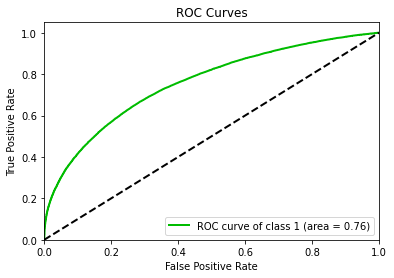

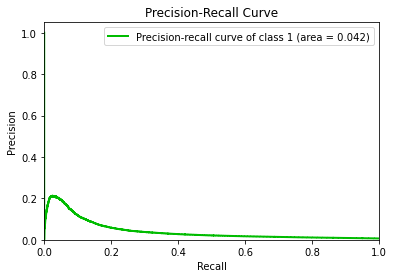

In [48]:
#Calculs des performances du modèles
performances(classifier1, X_test, y_test,scale=True)

In [49]:
end1 = time.time()
elapsed1 = end1 - start1

print(f'Temps d\'exécution : {elapsed1:.2}ms')

Temps d'exécution : 1.2e+02ms


**Importance des variables dans le modèle**

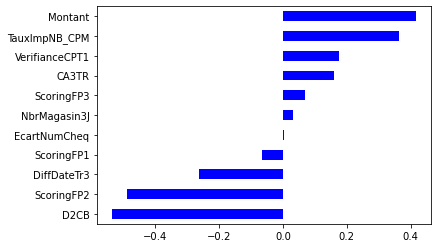

In [50]:
importances = pd.Series(model1.coef_[0], index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

In [27]:
#importances = pd.Series(clf1.feature_importances_, index = XTest.columns)
#sorted_importances = importances.sort_values()
#sorted_importances.plot(kind='barh', color='lightgreen')
#plt.show()

In [51]:
start2 = time.time()

In [52]:
# Definir le modèle de régression logistique avec Elesticnet
model2 = LogisticRegression(random_state=0, penalty='elasticnet', l1_ratio=0.5, solver='saga', C=0.01, max_iter=100)

In [53]:
clf2 = Pipeline([('SMOTE', resampling1), ('Logistic Regression', model2)])
classifier2=delayed(clf2.fit)(X_train_scale, y_train).compute() 

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet',
                                    random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.029949943084084746
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84   4616777
           1       0.02      0.65      0.03     29995

    accuracy                           0.73   4646772
   macro avg       0.51      0.69      0.44   4646772
weighted avg       0.99      0.73      0.84   4646772

-------------------------------------------------------
Matrice de confusion :
 [[3360021 1256756]
 [  10433   19562]]
-------------------------------------------------------
Auc Score :
 0.6899801759794375


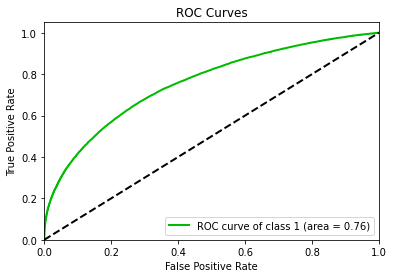

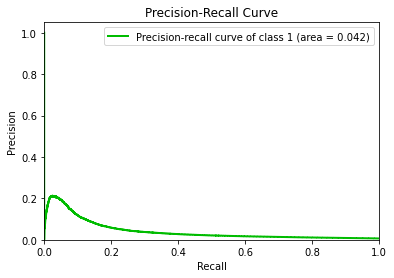

In [54]:
performances(classifier2, X_test, y_test,scale=True)

In [55]:
end2 = time.time()
elapsed2 = end2 - start2

print(f'Temps d\'exécution : {elapsed2:.2}ms')

Temps d'exécution : 1.2e+02ms


**Amélioration du F1_score avec modification du seuil**

In [56]:
start1bis = time.time()

In [57]:
 X_test_scale = scaler.transform(X_test)

In [58]:
sol1=modif_seuil(classifier1,X_test_scale,y_test)
sol1

'Threshold=0.900, F-Score=0.10881'

In [59]:
end1bis = time.time()
elapsed1bis = end1bis - start1bis

print(f'Temps d\'exécution : {elapsed1bis:.2}ms')

Temps d'exécution : 3.2e+01ms


In [60]:
sol2=modif_seuil(classifier2,X_test_scale,y_test)
sol2

'Threshold=0.900, F-Score=0.10883'

## 2. Arbre de décision

In [61]:
start3 = time.time()

In [62]:
model3 = DecisionTreeClassifier(random_state = 0)
clf3 = Pipeline([('SMOTE', resampling1), ('Arbre de décision', model3)])
classifier3=delayed(clf3.fit)(X_train_scale, y_train).compute() 

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Arbre de décision', DecisionTreeClassifier(random_state=0))])
-------------------------------------------------------
F1_score :
 0.9241809083183835
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4616777
           1       0.88      0.98      0.92     29995

    accuracy                           1.00   4646772
   macro avg       0.94      0.99      0.96   4646772
weighted avg       1.00      1.00      1.00   4646772

-------------------------------------------------------
Matrice de confusion :
 [[4612590    4187]
 [    631   29364]]
-------------------------------------------------------
Auc Score :
 0.9890281253964862
-------------------------------------------------------
Marge = 13815844.85 euros
------------------------------

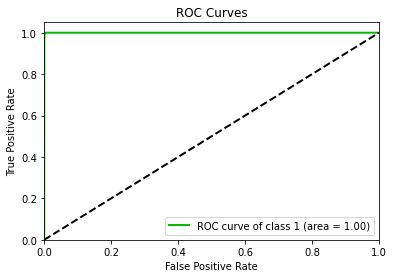

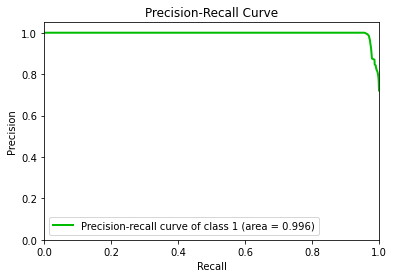

In [63]:
performances(classifier3, X_test, y_test,scale=True)

In [64]:
end3 = time.time()
elapsed3 = end3 - start3

print(f'Temps d\'exécution : {elapsed3:.2}ms')

Temps d'exécution : 2.7e+02ms


**Amélioration avec Adaboost**

In [65]:
start3bis = time.time()

In [66]:
AdaBoost = AdaBoostClassifier(base_estimator = model3, n_estimators = 10, random_state = 0)

# Structure de l'entrainement
classifier3bis = delayed(AdaBoost.fit)(X_train_scale, y_train).compute()

-------------------------------------------------------
Modèle :
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                   n_estimators=10, random_state=0)
-------------------------------------------------------
F1_score :
 0.9791589132861928
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4616777
           1       0.99      0.96      0.98     29995

    accuracy                           1.00   4646772
   macro avg       1.00      0.98      0.99   4646772
weighted avg       1.00      1.00      1.00   4646772

-------------------------------------------------------
Matrice de confusion :
 [[4616599     178]
 [   1054   28941]]
-------------------------------------------------------
Auc Score :
 0.9824111275498837
-------------------------------------------------------
Marge = 13814680.64 euros
----------------------------------

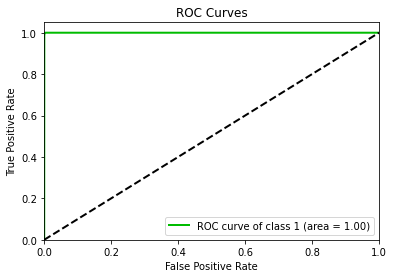

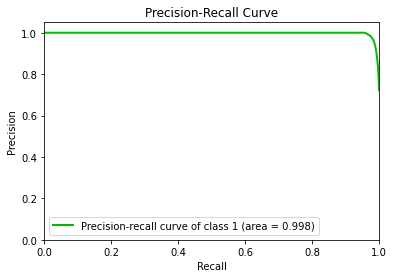

In [70]:
performances(classifier3bis, X_test, y_test,scale=True)

In [71]:
end3bis = time.time()
elapsed3bis = end3bis - start3bis

print(f'Temps d\'exécution : {elapsed3bis:.2}ms')

Temps d'exécution : 9.2e+02ms


## 3. Forêts aléatoires

In [72]:
start4 = time.time()

In [73]:
# Definir le modèle de régression logistique avec Elesticnet
model4 = RandomForestClassifier(n_estimators = 10, random_state = 0)
clf4 = Pipeline([('SMOTE', resampling1), ('Arbre de décision', model4)])
classifier4=delayed(clf4.fit)(X_train_scale, y_train).compute() 

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Arbre de décision',
                 RandomForestClassifier(n_estimators=10, random_state=0))])
-------------------------------------------------------
F1_score :
 0.9062543659479346
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4616777
           1       0.85      0.97      0.91     29995

    accuracy                           1.00   4646772
   macro avg       0.92      0.99      0.95   4646772
weighted avg       1.00      1.00      1.00   4646772

-------------------------------------------------------
Matrice de confusion :
 [[4611543    5234]
 [    805   29190]]
-------------------------------------------------------
Auc Score :
 0.9860142511906961
-------------------------------------------------------
Marge = 13809282.29 eu

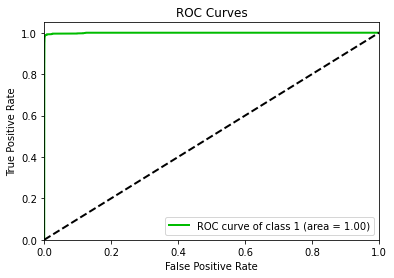

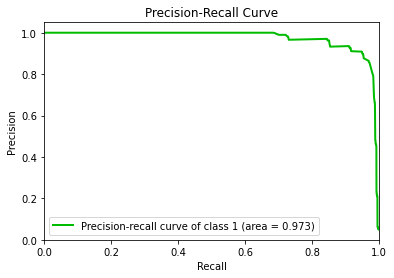

In [74]:
performances(classifier4, X_test, y_test,scale=True)

In [75]:
end4 = time.time()
elapsed4 = end4 - start4

print(f'Temps d\'exécution : {elapsed4:.2}ms')

Temps d'exécution : 6.3e+02ms


## 4. One Class SVM

In [109]:
X_test_scale = scaler.transform(X_test)

In [125]:
# On recode en -1 et 1 pour les besoins de ces algorithmes qui affectent un score de -1 ou 1
y_train_special = y_train.replace({1: -1, 0 : 1})
y_test_special = y_test.replace({1: -1, 0 : 1})

In [138]:
start5 = time.time()

In [139]:
model5 = linear_model.SGDOneClassSVM(nu = 0.0065, shuffle=True, fit_intercept=True, random_state= 2, tol=1e-7, max_iter = 2000)

# Kernel approximation

transform1 = Nystroem(kernel = 'poly', gamma=0.0005, n_components = 25, random_state = 2, degree = 5, coef0 = None)
clf5 = make_pipeline(transform1,model5)

# Entraînement
classifier5 = delayed(clf5.fit)(X_train_scale)

# Prédiction
y_pred5 = delayed(classifier5.predict)(X_test_scale).compute()

In [140]:
cm5 = delayed(confusion_matrix)(y_test_special, y_pred5).compute()
f1_1_5=delayed(f1_score)(y_test_special, y_pred5, pos_label = -1, average= 'binary').compute()
f1_0_5=delayed(f1_score)(y_test_special, y_pred5, pos_label = 1, average= 'binary').compute()
auc5=round(roc_auc_score(y_test_special, y_pred5), 4)
print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm5)
print("-------------------------------------------------------")
print('f1_score pour la classe 1 :\n', f1_1_5)
print('f1_score pour la classe 0 :\n', f1_0_5)
print("-------------------------------------------------------")
print('Auc Score :\n', auc5)

-------------------------------------------------------
Matrice de confusion :
 [[   2013   27982]
 [ 167051 4449726]]
-------------------------------------------------------
f1_score pour la classe 1 :
 0.020225159374858713
f1_score pour la classe 0 :
 0.9785548054672695
-------------------------------------------------------
Auc Score :
 0.5155


In [141]:
end5 = time.time()
elapsed5 = end5 - start5

print(f'Temps d\'exécution : {elapsed5:.2}ms')

Temps d'exécution : 3.5e+01ms


In [142]:
start6 = time.time()

In [143]:
model5 = linear_model.SGDOneClassSVM(nu = 0.0065, shuffle=True, fit_intercept=True, random_state= 2, tol=1e-7, max_iter = 2000)

# Kernel approximation

transform2 = Nystroem(kernel = 'rbf', gamma=0.0005, n_components = 25, random_state = 2, degree = 5, coef0 = None)
clf6 = make_pipeline(transform2,model5)

# Entraînement
classifier6 = delayed(clf6.fit)(X_train_scale)

# Prédiction
y_pred6 = delayed(classifier6.predict)(X_test_scale).compute()

In [144]:
cm6 = delayed(confusion_matrix)(y_test_special, y_pred6).compute()
f1_1_6=delayed(f1_score)(y_test_special, y_pred6, pos_label = -1, average= 'binary').compute()
f1_0_6=delayed(f1_score)(y_test_special, y_pred6, pos_label = 1, average= 'binary').compute()
auc6=round(roc_auc_score(y_test_special, y_pred6), 4)
print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm6)
print("-------------------------------------------------------")
print('f1_score pour la classe 1 :\n', f1_1_6)
print('f1_score pour la classe 0 :\n', f1_0_6)
print("-------------------------------------------------------")
print('Auc Score :\n', auc6)

-------------------------------------------------------
Matrice de confusion :
 [[  29995       0]
 [4616777       0]]
-------------------------------------------------------
f1_score pour la classe 1 :
 0.012827237277375588
f1_score pour la classe 0 :
 0.0
-------------------------------------------------------
Auc Score :
 0.5


In [146]:
end6 = time.time()
elapsed6 = end6 - start6

print(f'Temps d\'exécution : {elapsed6:.2}ms')

Temps d'exécution : 6.2e+01ms


In [147]:
start7 = time.time()

In [148]:
model5 = linear_model.SGDOneClassSVM(nu = 0.0065, shuffle=True, fit_intercept=True, random_state= 2, tol=1e-7, max_iter = 2000)

# Kernel approximation

transform3 = Nystroem(kernel = 'sigmoid', gamma=0.0005, n_components = 25, random_state = 2, degree = 5, coef0 = None)
clf7 = make_pipeline(transform3,model5)

# Entraînement
classifier7 = delayed(clf7.fit)(X_train_scale)

# Prédiction
y_pred7 = delayed(classifier7.predict)(X_test_scale).compute()

In [149]:
cm7 = delayed(confusion_matrix)(y_test_special, y_pred6).compute()
f1_1_7=delayed(f1_score)(y_test_special, y_pred7, pos_label = -1, average= 'binary').compute()
f1_0_7=delayed(f1_score)(y_test_special, y_pred7, pos_label = 1, average= 'binary').compute()
auc7=round(roc_auc_score(y_test_special, y_pred7), 4)

print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm7)
print("-------------------------------------------------------")
print('f1_score pour la classe 1 :\n', f1_1_7)
print('f1_score pour la classe 0 :\n', f1_0_7)
print("-------------------------------------------------------")
print('Auc Score :\n', auc7)

-------------------------------------------------------
Matrice de confusion :
 [[  29995       0]
 [4616777       0]]
-------------------------------------------------------
f1_score pour la classe 1 :
 0.020225057771526174
f1_score pour la classe 0 :
 0.9785546931524648
-------------------------------------------------------
Auc Score :
 0.5155


In [151]:
end7 = time.time()
elapsed7 = end7 - start7

print(f'Temps d\'exécution : {elapsed7:.2}ms')

Temps d'exécution : 6.1e+01ms


## 5. Auto_encoder - outlier detection

In [155]:
start8 = time.time()

In [156]:
# Entraînement sur les données train avec une contamination de 0.1
model8 = AutoEncoder(epochs=5, 
                   contamination=0.0065, 
                   hidden_neurons =[14, 2, 2, 14], 
                   batch_size = 1024)
model8.fit(X_train_scale)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dropout_1 (Dropout)         (None, 11)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                168       
                                                                 
 dropout_2 (Dropout)         (None, 14)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

AutoEncoder(batch_size=1024, contamination=0.0065, dropout_rate=0.2, epochs=5,
      hidden_activation='relu', hidden_neurons=[14, 2, 2, 14],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x00000199C7216310>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [158]:
# Classes affectées aux individus de par le modèle
y_label = model8.labels_
y_label

array([0, 0, 0, ..., 0, 0, 0])

In [159]:
# Prédiction
y_pred8 = model8.predict(X_test_scale)

145212/145212 [==============================] - 129s 888us/step


In [162]:
cm8 = confusion_matrix(y_test, y_pred8)
cf8 = classification_report(y_test, y_pred8,zero_division=0)
auc8 =round(roc_auc_score(y_test, y_pred8), 4)

print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm8)
print("-------------------------------------------------------")
print('Estimateurs :\n', cf8)
print("-------------------------------------------------------")
print('Auc Score :\n', auc8)

-------------------------------------------------------
Matrice de confusion :
 [[      0 4616777]
 [      0   29995]]
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00   4616777
           1       0.01      1.00      0.01     29995

    accuracy                           0.01   4646772
   macro avg       0.00      0.50      0.01   4646772
weighted avg       0.00      0.01      0.00   4646772

-------------------------------------------------------
Auc Score :
 0.5


In [161]:
end8 = time.time()
elapsed8 = end8 - start8

print(f'Temps d\'exécution : {elapsed8:.2}ms')

Temps d'exécution : 6.4e+02ms


In [163]:
start9 = time.time()

In [164]:
# Entraînement sur les données train
model9 = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[13, 6, 6, 13],
                   hidden_activation = 'softmax',
                   batch_size = 1024,
                   dropout_rate = 0.5,
                   random_state = 2,
                   l2_regularizer = 0.9,
                   loss = 'BinaryCrossentropy',
                   preprocessing = False)

model9.fit(X_train_scale)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 11)                132       
                                                                 
 dropout_6 (Dropout)         (None, 11)                0         
                                                                 
 dense_8 (Dense)             (None, 11)                132       
                                                                 
 dropout_7 (Dropout)         (None, 11)                0         
                                                                 
 dense_9 (Dense)             (None, 13)                156       
                                                                 
 dropout_8 (Dropout)         (None, 13)                0         
                                                                 
 dense_10 (Dense)            (None, 6)                

AutoEncoder(batch_size=1024, contamination=0.0065, dropout_rate=0.5,
      epochs=15, hidden_activation='softmax',
      hidden_neurons=[13, 6, 6, 13], l2_regularizer=0.9,
      loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [165]:
# Prédiction
y_pred9 = model9.predict(X_test_scale)

cm9 = confusion_matrix(y_test, y_pred9)
cf9 = classification_report(y_test, y_pred9,zero_division=0)
auc9 =round(roc_auc_score(y_test, y_pred9), 4)

print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm9)
print("-------------------------------------------------------")
print('Estimateurs :\n', cf9)
print("-------------------------------------------------------")
print('Auc Score :\n', auc9)

145212/145212 [==============================] - 129s 885us/step
-------------------------------------------------------
Matrice de confusion :
 [[      0 4616777]
 [      0   29995]]
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00   4616777
           1       0.01      1.00      0.01     29995

    accuracy                           0.01   4646772
   macro avg       0.00      0.50      0.01   4646772
weighted avg       0.00      0.01      0.00   4646772

-------------------------------------------------------
Auc Score :
 0.5


In [166]:
end9 = time.time()
elapsed9 = end9 - start9

print(f'Temps d\'exécution : {elapsed9:.2}ms')

Temps d'exécution : 7.2e+02ms


In [167]:
start10 = time.time()

In [168]:
# Entraînement sur les données train
model10 = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[8, 4, 2, 2, 4, 8],
                   hidden_activation = 'sigmoid',
                   batch_size = 768,
                   dropout_rate = 0.4,
                   random_state = 2,
                   l2_regularizer = 0.4,
                   loss = 'BinaryCrossentropy',
                   output_activation = 'sigmoid',
                   preprocessing = False)

model10.fit(X_train_scale)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 11)                132       
                                                                 
 dropout_12 (Dropout)        (None, 11)                0         
                                                                 
 dense_15 (Dense)            (None, 11)                132       
                                                                 
 dropout_13 (Dropout)        (None, 11)                0         
                                                                 
 dense_16 (Dense)            (None, 8)                 96        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 4)                

AutoEncoder(batch_size=768, contamination=0.0065, dropout_rate=0.4, epochs=15,
      hidden_activation='sigmoid', hidden_neurons=[8, 4, 2, 2, 4, 8],
      l2_regularizer=0.4, loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [169]:
# Prédiction
y_pred10 = model10.predict(X_test_scale)

cm10 = confusion_matrix(y_test, y_pred10)
cf10 = classification_report(y_test, y_pred10,zero_division=0)
auc10 =round(roc_auc_score(y_test, y_pred10), 4)

print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm10)
print("-------------------------------------------------------")
print('Estimateurs :\n', cf10)
print("-------------------------------------------------------")
print('Auc Score :\n', auc10)

145212/145212 [==============================] - 133s 913us/step
-------------------------------------------------------
Matrice de confusion :
 [[      0 4616777]
 [      0   29995]]
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00   4616777
           1       0.01      1.00      0.01     29995

    accuracy                           0.01   4646772
   macro avg       0.00      0.50      0.01   4646772
weighted avg       0.00      0.01      0.00   4646772

-------------------------------------------------------
Auc Score :
 0.5


In [170]:
end10 = time.time()
elapsed10 = end10 - start10

print(f'Temps d\'exécution : {elapsed10:.2}ms')

Temps d'exécution : 7.4e+02ms


**Novelty detection**

On va essayer d'entraîner le modèle uniquement sur la classe non frauduleuse et on prédira sur les deux classes.

In [171]:
#sélection de la classe 0 (classe non frauduleuse)
df_train0=df_train[df_train['FlagImpaye'] == 0]
df_test0=df_test[df_test['FlagImpaye'] == 0]

In [172]:
# Définir les variables explicatives 
X_train0 = df_train0.drop(["FlagImpaye"], axis = "columns")
X_test0 = df_test0.drop(["FlagImpaye"], axis = "columns")

In [173]:
# Centrer-réduire les dataframe d'apprentissage
X_train0_scale = scaler.fit_transform(X_train0)
X_test0_scale = scaler.fit_transform(X_test0)

In [174]:
start11 = time.time()

In [175]:
# Entraînement sur les données train 
model11 = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[8, 4, 2, 2, 4, 8],
                   hidden_activation = 'sigmoid',
                   batch_size = 768,
                   dropout_rate = 0.4,
                   random_state = 2,
                   l2_regularizer = 0.2,
                   loss = 'BinaryCrossentropy',
                   output_activation = 'sigmoid',
                   preprocessing = False)

model11.fit(X_train0_scale)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 11)                132       
                                                                 
 dropout_20 (Dropout)        (None, 11)                0         
                                                                 
 dense_24 (Dense)            (None, 11)                132       
                                                                 
 dropout_21 (Dropout)        (None, 11)                0         
                                                                 
 dense_25 (Dense)            (None, 8)                 96        
                                                                 
 dropout_22 (Dropout)        (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 4)                

AutoEncoder(batch_size=768, contamination=0.0065, dropout_rate=0.4, epochs=15,
      hidden_activation='sigmoid', hidden_neurons=[8, 4, 2, 2, 4, 8],
      l2_regularizer=0.2, loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [176]:
# Prédiction
y_pred11 = model11.predict(X_test_scale)

cm11 = confusion_matrix(y_test, y_pred11)
cf11 = classification_report(y_test, y_pred11,zero_division=0)
auc11 =round(roc_auc_score(y_test, y_pred11), 4)

print("-------------------------------------------------------")
print('Matrice de confusion :\n', cm11)
print("-------------------------------------------------------")
print('Estimateurs :\n', cf11)
print("-------------------------------------------------------")
print('Auc Score :\n', auc11)

145212/145212 [==============================] - 135s 929us/step
-------------------------------------------------------
Matrice de confusion :
 [[      0 4616777]
 [      0   29995]]
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00   4616777
           1       0.01      1.00      0.01     29995

    accuracy                           0.01   4646772
   macro avg       0.00      0.50      0.01   4646772
weighted avg       0.00      0.01      0.00   4646772

-------------------------------------------------------
Auc Score :
 0.5


In [177]:
end11 = time.time()
elapsed11 = end11 - start11

print(f'Temps d\'exécution : {elapsed11:.2}ms')

Temps d'exécution : 7.8e+02ms
